# Gradient Boosting and XGBoost: Theory and Implementation

## 1. Introduction

Gradient Boosting is a powerful ensemble machine learning technique that builds models sequentially, with each new model attempting to correct the errors of the combined ensemble of all previous models. XGBoost (eXtreme Gradient Boosting) is an optimized implementation of gradient boosting that has become one of the most successful algorithms in machine learning competitions and industrial applications.

## 2. Mathematical Foundation

### 2.1 The Boosting Framework

Given a training dataset $\{(x_i, y_i)\}_{i=1}^{n}$ where $x_i \in \mathbb{R}^d$ and $y_i \in \mathbb{R}$ (for regression), we seek to find a function $F(x)$ that minimizes a loss function $L(y, F(x))$.

In gradient boosting, we construct $F(x)$ as an additive model:

$$F_M(x) = \sum_{m=1}^{M} \gamma_m h_m(x)$$

where $h_m(x)$ are base learners (typically decision trees) and $\gamma_m$ are the corresponding weights.

### 2.2 Gradient Descent in Function Space

The key insight of gradient boosting is to perform gradient descent in function space. At each iteration $m$, we fit a new base learner to the negative gradient of the loss function:

$$r_{im} = -\left[\frac{\partial L(y_i, F(x_i))}{\partial F(x_i)}\right]_{F=F_{m-1}}$$

For squared error loss $L(y, F) = \frac{1}{2}(y - F)^2$, the negative gradient simplifies to the residual:

$$r_{im} = y_i - F_{m-1}(x_i)$$

### 2.3 XGBoost Objective Function

XGBoost uses a regularized objective function:

$$\mathcal{L}(\phi) = \sum_{i=1}^{n} L(y_i, \hat{y}_i) + \sum_{k=1}^{K} \Omega(f_k)$$

where the regularization term is:

$$\Omega(f) = \gamma T + \frac{1}{2}\lambda \sum_{j=1}^{T} w_j^2$$

Here, $T$ is the number of leaves in the tree, $w_j$ are the leaf weights, and $\gamma$, $\lambda$ are regularization parameters.

### 2.4 Second-Order Approximation

XGBoost uses a second-order Taylor expansion of the loss function. For adding a new tree $f_t$:

$$\mathcal{L}^{(t)} \approx \sum_{i=1}^{n} \left[g_i f_t(x_i) + \frac{1}{2} h_i f_t^2(x_i)\right] + \Omega(f_t)$$

where:
- $g_i = \frac{\partial L(y_i, \hat{y}_i^{(t-1)})}{\partial \hat{y}_i^{(t-1)}}$ (first-order gradient)
- $h_i = \frac{\partial^2 L(y_i, \hat{y}_i^{(t-1)})}{\partial (\hat{y}_i^{(t-1)})^2}$ (second-order gradient, Hessian)

### 2.5 Optimal Leaf Weights

For a fixed tree structure, the optimal weight for leaf $j$ is:

$$w_j^* = -\frac{\sum_{i \in I_j} g_i}{\sum_{i \in I_j} h_i + \lambda}$$

where $I_j$ is the set of instances assigned to leaf $j$.

### 2.6 Split Gain

The gain from splitting a leaf into left ($I_L$) and right ($I_R$) children is:

$$\text{Gain} = \frac{1}{2}\left[\frac{G_L^2}{H_L + \lambda} + \frac{G_R^2}{H_R + \lambda} - \frac{(G_L + G_R)^2}{H_L + H_R + \lambda}\right] - \gamma$$

where $G_L = \sum_{i \in I_L} g_i$, $H_L = \sum_{i \in I_L} h_i$, and similarly for $G_R$, $H_R$.

## 3. Implementation from Scratch

We will implement a simplified gradient boosting algorithm using decision trees as base learners to demonstrate the core concepts.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import make_regression, make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score

np.random.seed(42)

In [2]:
class GradientBoostingRegressorFromScratch:
    """
    A simplified Gradient Boosting Regressor implementation.
    
    Parameters:
    -----------
    n_estimators : int
        Number of boosting stages (trees)
    learning_rate : float
        Shrinkage parameter to prevent overfitting
    max_depth : int
        Maximum depth of individual trees
    """
    
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []
        self.initial_prediction = None
        
    def fit(self, X, y):
        """
        Fit the gradient boosting model.
        
        The algorithm:
        1. Initialize F_0(x) = mean(y)
        2. For m = 1 to M:
           a. Compute residuals r_im = y_i - F_{m-1}(x_i)
           b. Fit tree h_m to residuals
           c. Update: F_m(x) = F_{m-1}(x) + learning_rate * h_m(x)
        """
        # Initialize with mean prediction
        self.initial_prediction = np.mean(y)
        F = np.full(len(y), self.initial_prediction)
        
        self.training_losses = []
        
        for m in range(self.n_estimators):
            # Compute negative gradient (residuals for MSE loss)
            residuals = y - F
            
            # Fit a decision tree to residuals
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, residuals)
            self.trees.append(tree)
            
            # Update predictions
            F += self.learning_rate * tree.predict(X)
            
            # Track training loss
            loss = mean_squared_error(y, F)
            self.training_losses.append(loss)
            
        return self
    
    def predict(self, X):
        """
        Make predictions using the ensemble.
        """
        F = np.full(len(X), self.initial_prediction)
        for tree in self.trees:
            F += self.learning_rate * tree.predict(X)
        return F

## 4. Demonstration on Synthetic Data

In [3]:
# Generate synthetic regression data
X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, 
                       noise=10, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Training samples: 800
Test samples: 200


In [4]:
# Train our custom gradient boosting model
gb_custom = GradientBoostingRegressorFromScratch(
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=3
)
gb_custom.fit(X_train, y_train)

# Predictions
y_pred_train = gb_custom.predict(X_train)
y_pred_test = gb_custom.predict(X_test)

print(f"Train MSE: {mean_squared_error(y_train, y_pred_train):.4f}")
print(f"Test MSE: {mean_squared_error(y_test, y_pred_test):.4f}")

Train MSE: 63.7801
Test MSE: 172.3658


## 5. XGBoost-Style Implementation with Regularization

Now let's implement a more sophisticated version that includes XGBoost-style regularization.

In [5]:
class XGBoostStyleRegressor:
    """
    XGBoost-style gradient boosting with regularization.
    
    This implementation includes:
    - Second-order gradient information (Hessian)
    - L2 regularization on leaf weights (lambda)
    - Minimum split gain threshold (gamma)
    """
    
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3,
                 reg_lambda=1.0, gamma=0.0, min_child_weight=1):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.reg_lambda = reg_lambda  # L2 regularization
        self.gamma = gamma  # Minimum gain for split
        self.min_child_weight = min_child_weight
        self.trees = []
        self.initial_prediction = None
        
    def _compute_gradients(self, y_true, y_pred):
        """
        Compute first and second order gradients for MSE loss.
        
        For L(y, F) = 0.5 * (y - F)^2:
        - g = dL/dF = -(y - F) = F - y
        - h = d²L/dF² = 1
        """
        g = y_pred - y_true  # First-order gradient
        h = np.ones_like(y_true)  # Second-order gradient (Hessian)
        return g, h
    
    def _compute_optimal_weight(self, g, h):
        """
        Compute optimal leaf weight with L2 regularization.
        w* = -G / (H + lambda)
        """
        return -np.sum(g) / (np.sum(h) + self.reg_lambda)
    
    def fit(self, X, y):
        """
        Fit the XGBoost-style model.
        """
        self.initial_prediction = np.mean(y)
        y_pred = np.full(len(y), self.initial_prediction)
        
        self.training_losses = []
        
        for m in range(self.n_estimators):
            # Compute gradients
            g, h = self._compute_gradients(y, y_pred)
            
            # For MSE, fitting to -g/h is equivalent to fitting to residuals
            # In general XGBoost, the tree construction uses g and h directly
            # Here we use a simplified approach with sklearn trees
            pseudo_residuals = -g / h  # = y - y_pred for MSE
            
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, pseudo_residuals)
            self.trees.append(tree)
            
            # Update predictions with shrinkage
            y_pred += self.learning_rate * tree.predict(X)
            
            loss = mean_squared_error(y, y_pred)
            self.training_losses.append(loss)
            
        return self
    
    def predict(self, X):
        y_pred = np.full(len(X), self.initial_prediction)
        for tree in self.trees:
            y_pred += self.learning_rate * tree.predict(X)
        return y_pred

In [6]:
# Train XGBoost-style model
xgb_style = XGBoostStyleRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    reg_lambda=1.0
)
xgb_style.fit(X_train, y_train)

y_pred_xgb_train = xgb_style.predict(X_train)
y_pred_xgb_test = xgb_style.predict(X_test)

print(f"XGBoost-style Train MSE: {mean_squared_error(y_train, y_pred_xgb_train):.4f}")
print(f"XGBoost-style Test MSE: {mean_squared_error(y_test, y_pred_xgb_test):.4f}")

XGBoost-style Train MSE: 63.7801
XGBoost-style Test MSE: 172.3641


## 6. Visualizing the Boosting Process

In [7]:
# Create a 1D example for visualization
np.random.seed(42)
X_1d = np.linspace(0, 10, 200).reshape(-1, 1)
y_1d = np.sin(X_1d.ravel()) + 0.5 * np.cos(2 * X_1d.ravel()) + np.random.normal(0, 0.1, 200)

# Train models with different numbers of estimators
n_stages = [1, 5, 10, 50, 100]
predictions_at_stages = {}

for n in n_stages:
    model = GradientBoostingRegressorFromScratch(n_estimators=n, learning_rate=0.1, max_depth=2)
    model.fit(X_1d, y_1d)
    predictions_at_stages[n] = model.predict(X_1d)

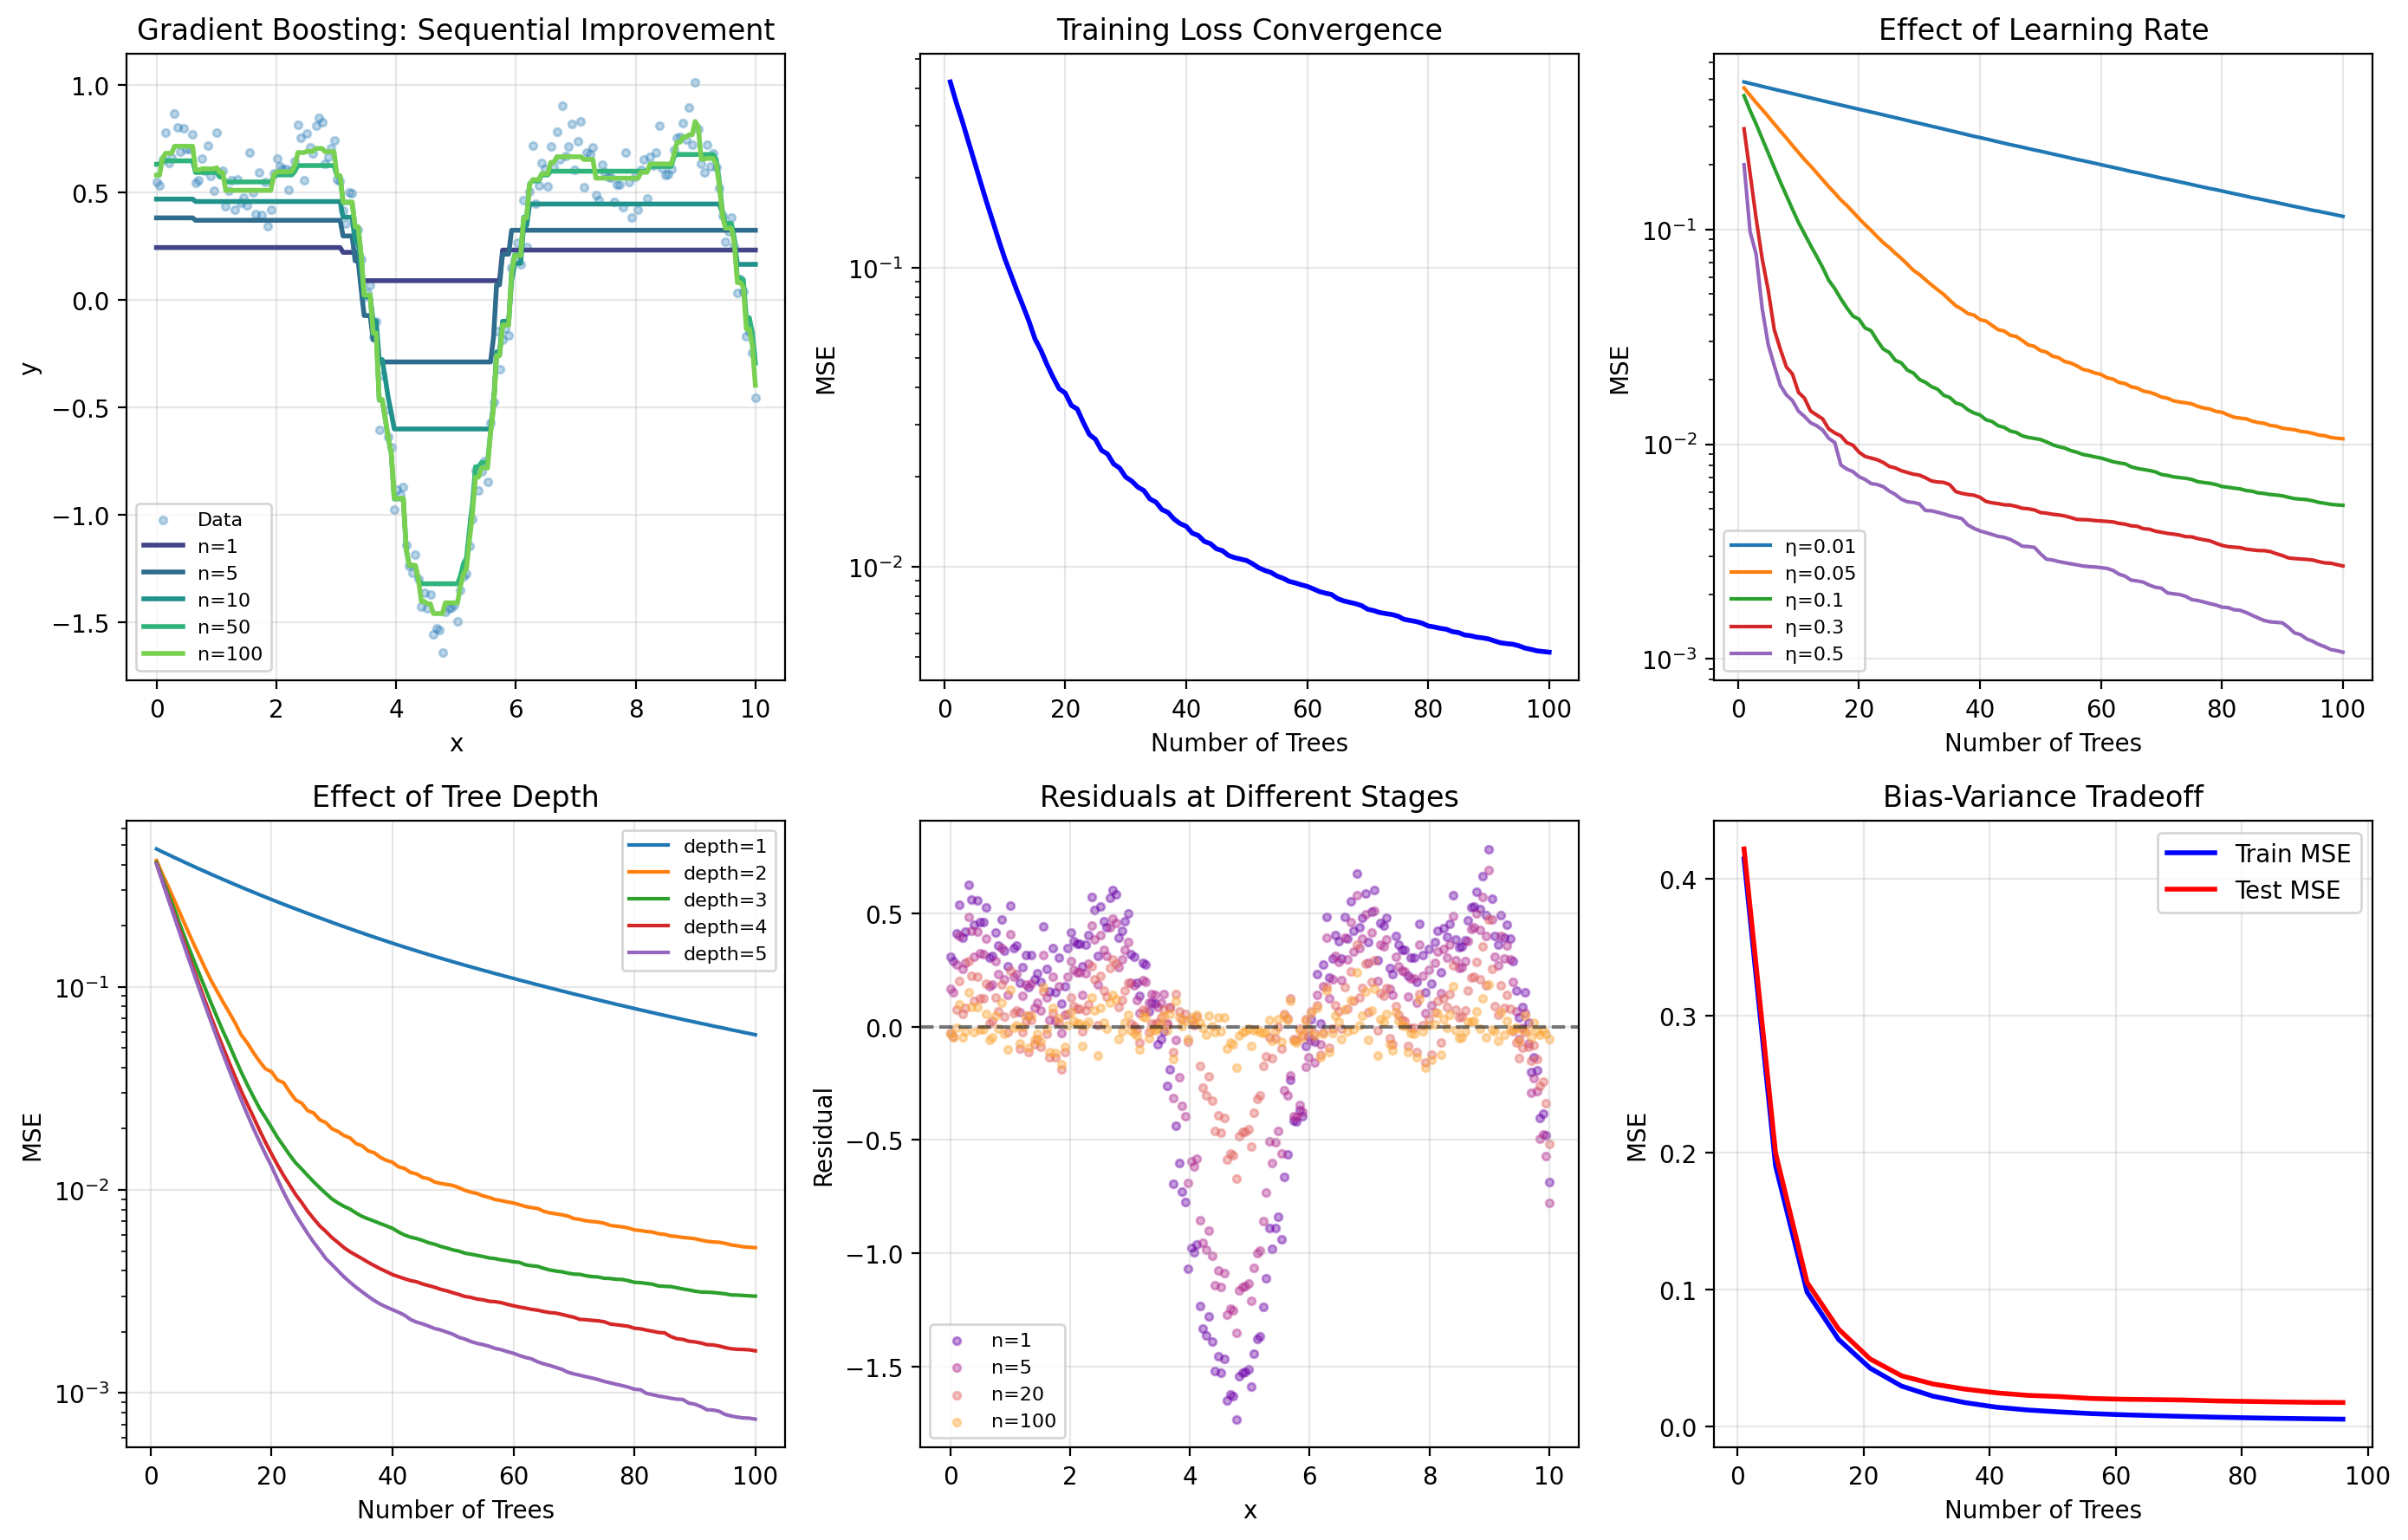

Plot saved to plot.png


In [8]:
# Visualization
fig, axes = plt.subplots(2, 3, figsize=(14, 9))
axes = axes.flatten()

# Plot 1: Data and predictions at different stages
ax = axes[0]
ax.scatter(X_1d, y_1d, alpha=0.3, s=10, label='Data')
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(n_stages)))
for (n, pred), color in zip(predictions_at_stages.items(), colors):
    ax.plot(X_1d, pred, label=f'n={n}', color=color, linewidth=2)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Gradient Boosting: Sequential Improvement')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Plot 2: Training loss convergence
ax = axes[1]
full_model = GradientBoostingRegressorFromScratch(n_estimators=100, learning_rate=0.1, max_depth=2)
full_model.fit(X_1d, y_1d)
ax.plot(range(1, 101), full_model.training_losses, 'b-', linewidth=2)
ax.set_xlabel('Number of Trees')
ax.set_ylabel('MSE')
ax.set_title('Training Loss Convergence')
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

# Plot 3: Effect of learning rate
ax = axes[2]
learning_rates = [0.01, 0.05, 0.1, 0.3, 0.5]
for lr in learning_rates:
    model = GradientBoostingRegressorFromScratch(n_estimators=100, learning_rate=lr, max_depth=2)
    model.fit(X_1d, y_1d)
    ax.plot(range(1, 101), model.training_losses, label=f'η={lr}', linewidth=1.5)
ax.set_xlabel('Number of Trees')
ax.set_ylabel('MSE')
ax.set_title('Effect of Learning Rate')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

# Plot 4: Effect of tree depth
ax = axes[3]
depths = [1, 2, 3, 4, 5]
for d in depths:
    model = GradientBoostingRegressorFromScratch(n_estimators=100, learning_rate=0.1, max_depth=d)
    model.fit(X_1d, y_1d)
    ax.plot(range(1, 101), model.training_losses, label=f'depth={d}', linewidth=1.5)
ax.set_xlabel('Number of Trees')
ax.set_ylabel('MSE')
ax.set_title('Effect of Tree Depth')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

# Plot 5: Residuals at different stages
ax = axes[4]
stages_to_show = [1, 5, 20, 100]
colors = plt.cm.plasma(np.linspace(0.2, 0.8, len(stages_to_show)))

for stage, color in zip(stages_to_show, colors):
    model = GradientBoostingRegressorFromScratch(n_estimators=stage, learning_rate=0.1, max_depth=2)
    model.fit(X_1d, y_1d)
    residuals = y_1d - model.predict(X_1d)
    ax.scatter(X_1d, residuals, alpha=0.4, s=10, label=f'n={stage}', color=color)
ax.axhline(y=0, color='k', linestyle='--', alpha=0.5)
ax.set_xlabel('x')
ax.set_ylabel('Residual')
ax.set_title('Residuals at Different Stages')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Plot 6: Bias-Variance Tradeoff illustration
ax = axes[5]
n_trees_range = np.arange(1, 101, 5)
train_errors = []
test_errors = []

# Split 1D data
X_1d_train, X_1d_test, y_1d_train, y_1d_test = train_test_split(
    X_1d, y_1d, test_size=0.3, random_state=42
)

for n in n_trees_range:
    model = GradientBoostingRegressorFromScratch(n_estimators=n, learning_rate=0.1, max_depth=2)
    model.fit(X_1d_train, y_1d_train)
    train_errors.append(mean_squared_error(y_1d_train, model.predict(X_1d_train)))
    test_errors.append(mean_squared_error(y_1d_test, model.predict(X_1d_test)))

ax.plot(n_trees_range, train_errors, 'b-', label='Train MSE', linewidth=2)
ax.plot(n_trees_range, test_errors, 'r-', label='Test MSE', linewidth=2)
ax.set_xlabel('Number of Trees')
ax.set_ylabel('MSE')
ax.set_title('Bias-Variance Tradeoff')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('gradient_boosting_xgboost_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("Plot saved to plot.png")

## 7. Classification with Gradient Boosting

For binary classification, we use the logistic loss (cross-entropy):

$$L(y, F) = -[y \log(p) + (1-y) \log(1-p)]$$

where $p = \sigma(F) = \frac{1}{1 + e^{-F}}$ is the sigmoid function.

The gradients become:
- $g_i = p_i - y_i$
- $h_i = p_i(1 - p_i)$

In [9]:
class GradientBoostingClassifierFromScratch:
    """
    Gradient Boosting Classifier using logistic loss.
    """
    
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []
        self.initial_prediction = None
        
    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))
    
    def _log_odds(self, p):
        p = np.clip(p, 1e-10, 1 - 1e-10)
        return np.log(p / (1 - p))
    
    def fit(self, X, y):
        # Initialize with log-odds of mean
        p_mean = np.mean(y)
        self.initial_prediction = self._log_odds(p_mean)
        F = np.full(len(y), self.initial_prediction)
        
        self.training_losses = []
        
        for m in range(self.n_estimators):
            # Compute probabilities and gradients
            p = self._sigmoid(F)
            g = p - y  # Gradient
            h = p * (1 - p)  # Hessian
            
            # Fit tree to negative gradient
            residuals = -g
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, residuals)
            self.trees.append(tree)
            
            # Update predictions
            F += self.learning_rate * tree.predict(X)
            
            # Log loss
            p_new = self._sigmoid(F)
            p_new = np.clip(p_new, 1e-10, 1 - 1e-10)
            loss = -np.mean(y * np.log(p_new) + (1 - y) * np.log(1 - p_new))
            self.training_losses.append(loss)
            
        return self
    
    def predict_proba(self, X):
        F = np.full(len(X), self.initial_prediction)
        for tree in self.trees:
            F += self.learning_rate * tree.predict(X)
        return self._sigmoid(F)
    
    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int)

In [10]:
# Generate classification data
X_clf, y_clf = make_classification(
    n_samples=1000, n_features=10, n_informative=5,
    n_redundant=2, random_state=42
)

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42
)

# Train classifier
gb_clf = GradientBoostingClassifierFromScratch(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3
)
gb_clf.fit(X_train_clf, y_train_clf)

# Evaluate
train_acc = accuracy_score(y_train_clf, gb_clf.predict(X_train_clf))
test_acc = accuracy_score(y_test_clf, gb_clf.predict(X_test_clf))

print(f"Classification Results:")
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Classification Results:
Train Accuracy: 0.9463
Test Accuracy: 0.9400


## 8. Key Takeaways

### Gradient Boosting Core Concepts:

1. **Sequential Learning**: Each tree corrects errors made by the ensemble of previous trees

2. **Gradient Descent in Function Space**: The algorithm fits trees to negative gradients of the loss function

3. **Shrinkage (Learning Rate)**: The parameter $\eta$ controls the contribution of each tree:
   - Small $\eta$: More trees needed, better generalization, slower training
   - Large $\eta$: Fewer trees sufficient, risk of overfitting, faster training

### XGBoost Innovations:

1. **Regularization**: $\Omega(f) = \gamma T + \frac{1}{2}\lambda||w||^2$ prevents overfitting

2. **Second-Order Optimization**: Uses both gradient $g$ and Hessian $h$ for better optimization

3. **Optimal Split Finding**: Gain-based criterion with regularization:
   $$\text{Gain} = \frac{1}{2}\left[\frac{G_L^2}{H_L + \lambda} + \frac{G_R^2}{H_R + \lambda} - \frac{(G_L + G_R)^2}{H_L + H_R + \lambda}\right] - \gamma$$

4. **Sparsity Awareness**: Efficient handling of missing values

5. **Parallel Processing**: Column block structure enables parallel tree construction

## 9. References

1. Friedman, J. H. (2001). Greedy function approximation: A gradient boosting machine. *Annals of Statistics*, 29(5), 1189-1232.

2. Chen, T., & Guestrin, C. (2016). XGBoost: A scalable tree boosting system. *Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining*.

3. Hastie, T., Tibshirani, R., & Friedman, J. (2009). *The Elements of Statistical Learning* (2nd ed.). Springer.